In [1]:
import pandas as pd
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter
import matplotlib as mpl
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import warnings
from scipy.misc import derivative
from scipy.integrate import quad
warnings.filterwarnings('ignore')

In [2]:
Gene_list = ['ADA2','PRS3','ASC1','RAD6','BFR1','RPL29', \
             'BUD23','RPL39','CCW12','RPS7A','EOS1','SNF6','GET1',\
             'TSR2','GIM5','VMA21','IES6','VMA7','LSM1','EST1','PAF1']
df_YPD = pd.DataFrame()

for Gene in Gene_list:
    df_gene = pd.read_csv(f'../../Xukang/Mutants/{Gene}.txt', 
                     delim_whitespace=True)
    df_gene['Gene'] = Gene
    df_YPD = pd.concat([df_YPD,df_gene],ignore_index=True)
df_YPD = df_YPD[df_YPD['Mutation_type'] != 'Nonsense_mutation']

df_YPD.iloc[:,2:6] = np.log(df_YPD.iloc[:,2:6])
df_YPD['YPD_fitness'] = df_YPD[[f'Fitness_from_YPD_replicate_{i}' for i in range(1,5)]].mean(axis=1)

In [3]:
idx_nonsyn = df_YPD['Mutation_type'] == 'Nonsynonymous_mutation'
non_E_distribution = df_YPD[idx_nonsyn]['YPD_fitness'].to_numpy().flatten()
non_cdf = ECDF(non_E_distribution)

In [4]:
def get_logfixP(x,Ne=1e7):
    if x*Ne < -100:
        y_logfixP = np.log10(np.exp(-2*x)-1) - np.log10(np.e)*(-4*Ne*x)
    else:
        y_logfixP = np.log10((1 - np.exp(-2*x))/(1-np.exp(-4*Ne*x)))
    return y_logfixP

In [7]:
rcParams_dict = {
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
}
mpl.rcParams.update(rcParams_dict)

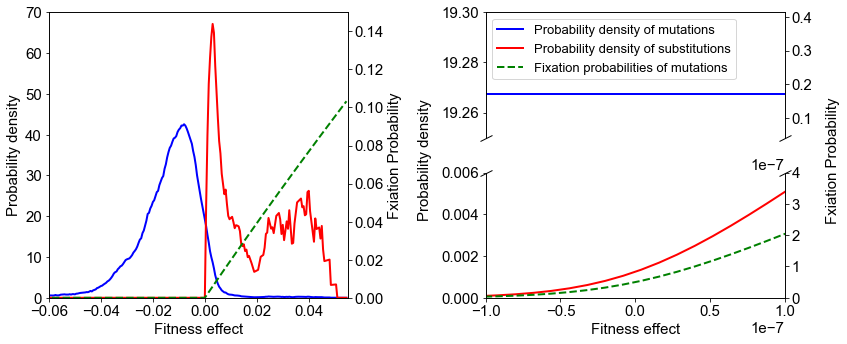

In [8]:
Ne = 1e7
interval_list = [0.0005,0.12/Ne,0.12/Ne]
x_range_list = [np.arange(-0.11, 0.055, interval_list[0]),
                np.arange(-2/Ne, 2/Ne, interval_list[1]),
                np.arange(-2/Ne, 2/Ne, interval_list[1])]
xlim_list = [(-0.06,0.055),(-1/Ne,1/Ne),(-1/Ne,1/Ne)]
ylim_list = [(0,0.15),(0,4/Ne),(0.04125,0.4136)]

#fig,axes = plt.subplots(1,2,figsize=[12,5],facecolor='w')
fig = plt.figure(figsize=(12, 5), constrained_layout=True, facecolor='w')
spec = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(spec[:, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax11 = fig.add_subplot(spec[1, 1])

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

axes = [ax0,ax11,ax01]
for i,ax1 in enumerate(axes):
    x = x_range_list[i]
    ax2 = ax1.twinx()
    y_YPD = derivative(non_cdf, x, dx=3e-3)
    line1 = ax1.plot(x,y_YPD,'b',label='Probability density of mutations',linewidth=2)
    
    y_fixP = (1 - np.exp(-2*x))/(1-np.exp(-4*Ne*x))
    y_logfixP = []
    if i == 0:
        denumerator = (y_YPD * y_fixP * interval_list[i]).sum()
    y_joinP = (y_YPD * y_fixP) / denumerator
    line2 = ax1.plot(x,y_joinP,'r',label='Probability density of substitutions',linewidth=2)
    ax1.set_xlim(xlim_list[i])

    #for xx in x:
    #    y_logfixP.append(get_logfixP(xx))
    line3 = ax2.plot(x,y_fixP,'g--',label='Fixation probabilities of mutations',linewidth=2)
    ax2.set_xlim(xlim_list[i])
    ax2.set_ylim(ylim_list[i])
    
    if i == 0:
        ax1.set_ylim(0,70)
    elif i == 1:
        ax1.set_ylim(0,0.006)
        ax1.spines.top.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax1.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
        ax1.yaxis.set_label_coords(-.18, 1.1) # adjust position of "Probability density" in panel B
        ax2.yaxis.set_label_coords(1.14, 1.1) # adjust position of "Fixation Probability" in panel B
    elif i == 2:
        #ax01.plot(x,y_YPD,'b',label='Fitness effects of mutations')
        ax1.set_ylim(19.25,19.3)
        ax1.spines.bottom.set_visible(False)
        ax2.spines.bottom.set_visible(False)
        ax1.tick_params(labelbottom=False)  # don't put tick labels at the top
        ax1.set_xticks([])
        #ax2.set_yticks([])
        ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
        
        lines = line1 + line2 + line3
        labs = [l.get_label() for l in lines]  
        ax1.legend(lines, labs, loc='upper left',prop={'size': 13})
        
    if i != 2:
        ax1.set_xlabel('Fitness effect')
        ax1.set_ylabel('Probability density')
        ax2.set_ylabel('Fixation Probability')
        

plt.tight_layout(pad=1)
#plt.show()
plt.savefig('./Figures/Fig1_upper.pdf')